# Predicting Songs for a Korean Indie/Rnb Playlist - Spotify Web API Project

One of my favorite genres of music is Korean Indie/Rnb. I'm a huge fan of artists such as Dean, Colde, and Zion T but I've definitely overrun how many times I've played each of their albums. Spotify's playlists are great to discover new music, but I've found several limitations:

1. I either have to trust the curation of the playlist blindly which can lead to disappointment
2. I have to spot check the songs to see if I actually enjoy them which is time consuming
3. My hypothesis is the playlists are curated by my listening activity or Liked Songs which can veer outside of Korean Indie/Rnb which feeds all kind of songs on my primary discovery playlist: Discover Weekly

Therefore, I wanted to use Spotify's API to build my own model to assess which songs belong in my Korean Indie/Rnb Playlist to hopefully solve each of the painpoints above when I'm curating my personal playlist.

## My Approach

The model I build will be a classification model that provides a binary outcome for whether a certain song belongs in the playlist (1.0) or does not belong (0.0).

I will be training the model with two playlists:

1. My current Korean Indie/Rnb playlist (1.0)
2. A generic popular Kpop playlist (0.0)

Lastly, I will assess my model's performance on my current Discovery Weekly (DW) playlist to see which songs from my DW belong in my Korean Indie/Rnb playlist.

In [288]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [241]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import statsmodels.api as sm

client_id = 'bc6b496d4a0945f5b9c66ee309db8335' #from Spotify Dashboard
client_secret = 'dfe7624598d640e49329c91e8ca92dd2' #from Spotify Dashboard

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlist_id = '32eqF8oMMNtyvYHBlecdSO'
results = sp.playlist(playlist_id)

In [242]:
#creating list of song ids

ids = []

for item in results['tracks']['items']:
    track = item['track']['id']
    ids.append(track)

song_meta = {'id':[], 'album':[], 'name':[], 'artist':[], 'explicit':[], 'popularity':[]}

for song_id in ids:
    #getting song's meta data
    meta = sp.track(song_id)
    
    #song id
    song_meta['id'].append(song_id)
    
    #album name
    album = meta['album']['name']
    song_meta['album'] += [album]
    
    #song name
    song = meta['name']
    song_meta['name'] += [song]
    
    #artists name
    s = ', '
    artist = s.join([singer_name['name'] for singer_name in meta['artists']])
    song_meta['artist'] += [artist]
    
    #explicit
    explicit = meta['explicit']
    song_meta['explicit'].append(explicit)
    
    #song popularity
    popularity = meta['popularity']
    song_meta['popularity'].append(popularity)

song_meta_df = pd.DataFrame.from_dict(song_meta)

#check song features

features = sp.audio_features(song_meta['id'])

#change dictionary to dataframe

features_df = pd.DataFrame.from_dict(features)

#convert milliseconds to mins
#duration_ms: The duration of the track in milliseconds
#1 minute = 60 seconds = 60 * 1,000 milliseconds = 60,000 ms
features_df['duration_ms'] = features_df['duration_ms']/60000

#combine the two dataframes

final_df = song_meta_df.merge(features_df)

In [243]:
final_df.head()

,id,album,name,artist,explicit,popularity,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,4fJCpN7FSKLMt22aKQxSuJ,sleepless in __________,Eternal Sunshine,Epik High,False,51,0.847,0.713,2,-6.267,...,0.000000,0.0821,0.686,97.021,audio_features,spotify:track:4fJCpN7FSKLMt22aKQxSuJ,https://api.spotify.com/v1/tracks/4fJCpN7FSKLM...,https://api.spotify.com/v1/audio-analysis/4fJC...,3.423150,4
1,6z1kLsntE7FuzKZHZWrXYN,instagram,instagram,DEAN,False,72,0.463,0.566,8,-6.195,...,0.000000,0.2840,0.219,93.921,audio_features,spotify:track:6z1kLsntE7FuzKZHZWrXYN,https://api.spotify.com/v1/tracks/6z1kLsntE7Fu...,https://api.spotify.com/v1/audio-analysis/6z1k...,4.262150,4
2,3uA8SjMyDtwtt0jLPMQbVD,130 Mood : TRBL,D (Half Moon),"DEAN, Gaeko",False,67,0.512,0.765,7,-5.252,...,0.000000,0.0573,0.519,169.709,audio_features,spotify:track:3uA8SjMyDtwtt0jLPMQbVD,https://api.spotify.com/v1/tracks/3uA8SjMyDtwt...,https://api.spotify.com/v1/audio-analysis/3uA8...,3.822667,4
3,2IgbYlOlFpiSFYnsqB39lM,Jasmine,Jasmine,DPR LIVE,False,68,0.597,0.486,8,-5.893,...,0.000000,0.1400,0.397,137.680,audio_features,spotify:track:2IgbYlOlFpiSFYnsqB39lM,https://api.spotify.com/v1/tracks/2IgbYlOlFpiS...,https://api.spotify.com/v1/audio-analysis/2Igb...,3.358517,4
4,14p5EKgbPx4U3P1j5JNHeh,boy.,"Cigarette (Feat. Tablo, MISO)","offonoff, Tablo, Miso",False,62,0.776,0.392,5,-10.493,...,0.000002,0.1400,0.438,87.980,audio_features,spotify:track:14p5EKgbPx4U3P1j5JNHeh,https://api.spotify.com/v1/tracks/14p5EKgbPx4U...,https://api.spotify.com/v1/audio-analysis/14p5...,4.029417,4


In [244]:
#average values for each audio feature

music_feature = features_df[['danceability','energy','loudness','speechiness','acousticness',
                             'instrumentalness','liveness','valence','tempo','duration_ms']]

music_feature.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.680430,0.534400,-7.279470,0.116684,0.464017,0.021196,0.197345,0.495462,115.901880,3.592702
std,0.139828,0.173698,2.544279,0.103694,0.260728,0.123761,0.140348,0.227022,28.017485,0.677352
min,0.351000,0.177000,-16.499000,0.025600,0.020600,0.000000,0.057300,0.059800,68.027000,1.945983
25%,0.595250,0.391250,-8.570000,0.044500,0.245250,0.000000,0.105750,0.336500,91.501500,3.250979
50%,0.700000,0.531500,-6.695500,0.069850,0.494500,0.000000,0.131000,0.499000,113.870000,3.534767
75%,0.791000,0.650500,-5.595750,0.152000,0.648750,0.000039,0.259500,0.655750,134.486250,3.883333
max,0.955000,0.949000,-2.723000,0.578000,0.955000,0.883000,0.767000,0.937000,183.936000,6.416667


## Data Preprocessing

Some features have very high values (e.g. tempo), while other features have extremely low values (e.g. instrumentalness). To ensure we are fairly weighting each audio feature when building a model to assess whether other songs would fit well in our playlist, we need to apply feature scaling.

I will be using normalization, which is a scaling technique to which values are shifted and rescaled so they end up ranging betwen 0 and 1. It is also known as Min-Max scaling.

In [245]:
from sklearn.preprocessing import MinMaxScaler

pd.options.mode.chained_assignment = None  # default='warn'

min_max_scaler = MinMaxScaler()

music_feature.loc[:] = min_max_scaler.fit_transform(music_feature.loc[:])

In [246]:
music_feature.describe()

#all audio features rescaled to range between 0 and 1

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.545414,0.462953,0.669246,0.164888,0.474547,0.024004,0.197330,0.496651,0.413039,0.368337
std,0.231503,0.224998,0.184689,0.187716,0.279032,0.140159,0.197756,0.258803,0.241720,0.151510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.404387,0.277526,0.575566,0.034214,0.240422,0.000000,0.068268,0.315435,0.202525,0.291901
50%,0.577815,0.459197,0.711636,0.080105,0.507170,0.000000,0.103847,0.500684,0.395509,0.355378
75%,0.728477,0.613342,0.791467,0.228820,0.672250,0.000044,0.284909,0.679378,0.573374,0.433345
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Regression Analysis for Korean Indie RnB Playlist

So far, I've aggregated the music features for my Korean Indie RnB Playlist. However, I want to be able to assess whether new songs I discover would be a good fit for my playlist based on their audio features.

To be able to do this, I need to create a binary variable that marks a song as on my playlist or test with my sample data to build a regression model.

In addition, I will need to curate songs that do not belong on the playlist to better train the model in understanding which audio features are found on songs that do not belong on the playlist.

To do this I will:

1. Assign binary variable with value of 1.00 to all songs in final_df
2. Build a second dataframe from a different playlist I pull from Spotify's API that contains music that will not fit in the Korean Indie RnB playlist
3. Assign binary variable with value of 0.00 to all songs in alternate df
4. Merge the two dataframes

In [247]:
#adding binary variable "playlist" with value of 1.000 to all songs from Korean Indie RnB playlist
music_feature['playlist'] = 1.00

In [248]:
music_feature.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist
0,0.821192,0.694301,0.742741,0.451484,0.179152,0.000000,0.034944,0.713862,0.250145,0.330412,1.0
1,0.185430,0.503886,0.747967,0.216148,0.187714,0.000000,0.319431,0.181487,0.223399,0.518079,1.0
2,0.266556,0.761658,0.816420,0.199855,0.241224,0.000000,0.000000,0.523484,0.877257,0.419776,1.0
3,0.407285,0.400259,0.769890,0.132151,0.332192,0.000000,0.116528,0.384405,0.600928,0.315955,1.0
4,0.703642,0.278497,0.435976,0.328385,0.267979,0.000003,0.116528,0.431145,0.172144,0.466021,1.0


To ensure a fairer comparison between the songs that are already on the Korean Indie RnB Playlist and the second playlist I'll use to assign a 0.0 value to the "playlist" variable, I'll be using the KPop Top Hits 2021 Playlist on Spotify (https://open.spotify.com/playlist/3kwb1LyzCSsLLacppOJQc8?si=d68abf3c27524e41)

This way we're still comparing the a similar category/genre/culture of music for our test data, yet hopefully able to distinguish between the mainstream Kpop songs versus the more underground Korean Indie songs.

In [249]:
playlist_id_2 = '3kwb1LyzCSsLLacppOJQc8'
results_non_kindie = sp.playlist(playlist_id_2)

In [250]:
#Converting json data to Dataframe

ids_2 = []

for item in results_non_kindie['tracks']['items']:
    track_2 = item['track']['id']
    ids_2.append(track_2)

song_meta_2 = {'id':[], 'album':[], 'name':[], 'artist':[], 'explicit':[], 'popularity':[]}

for song_id_2 in ids_2:
    #getting song's meta data
    meta_2 = sp.track(song_id_2)
    
    #song id
    song_meta_2['id'].append(song_id_2)
    
    #album name
    album_2 = meta_2['album']['name']
    song_meta_2['album'] += [album_2]
    
    #song name
    song_2 = meta_2['name']
    song_meta_2['name'] += [song_2]
    
    #artists name
    s_2 = ', '
    artist_2 = s_2.join([singer_name_2['name'] for singer_name_2 in meta_2['artists']])
    song_meta_2['artist'] += [artist_2]
    
    #explicit
    explicit_2 = meta_2['explicit']
    song_meta_2['explicit'].append(explicit_2)
    
    #song popularity
    popularity_2 = meta_2['popularity']
    song_meta_2['popularity'].append(popularity_2)

song_meta_df_2 = pd.DataFrame.from_dict(song_meta_2)

#check song features

features_2 = sp.audio_features(song_meta_2['id'])

#change dictionary to dataframe

features_df_2 = pd.DataFrame.from_dict(features_2)

#convert milliseconds to mins
#duration_ms: The duration of the track in milliseconds
#1 minute = 60 seconds = 60 * 1,000 milliseconds = 60,000 ms
features_df_2['duration_ms'] = features_df_2['duration_ms']/60000

#combine the two dataframes

final_df_2 = song_meta_df_2.merge(features_df_2)

In [251]:
final_df_2.head()

,id,album,name,artist,explicit,popularity,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,2J0TRU2EDG29qlmxdGa4xa,Formula of Love: O+T=<3,SCIENTIST,TWICE,False,67,0.786,0.858,11,-3.740,...,0.0000,0.1260,0.649,112.999,audio_features,spotify:track:2J0TRU2EDG29qlmxdGa4xa,https://api.spotify.com/v1/tracks/2J0TRU2EDG29...,https://api.spotify.com/v1/audio-analysis/2J0T...,3.243333,4
1,2NlTJ3Jf6skIJfTD0oJatY,Beautiful Breakup,Beautiful Breakup,LUNA,False,53,0.659,0.708,1,-3.446,...,0.0000,0.3420,0.450,93.980,audio_features,spotify:track:2NlTJ3Jf6skIJfTD0oJatY,https://api.spotify.com/v1/tracks/2NlTJ3Jf6skI...,https://api.spotify.com/v1/audio-analysis/2NlT...,4.123333,4
2,1A3T3npKsrElQTjTEcr3LR,Shivers (feat. Jessi & SUNMI),Shivers (feat. Jessi & SUNMI),"Ed Sheeran, Jessi, SUNMI",False,71,0.739,0.873,2,-2.595,...,0.0000,0.0454,0.863,141.026,audio_features,spotify:track:1A3T3npKsrElQTjTEcr3LR,https://api.spotify.com/v1/tracks/1A3T3npKsrEl...,https://api.spotify.com/v1/audio-analysis/1A3T...,3.464450,4
3,3QD0Y1tTngihByjdWC99lG,Killing Me,Killing Me,CHUNG HA,False,74,0.722,0.851,10,-2.589,...,0.0000,0.0661,0.763,122.012,audio_features,spotify:track:3QD0Y1tTngihByjdWC99lG,https://api.spotify.com/v1/tracks/3QD0Y1tTngih...,https://api.spotify.com/v1/audio-analysis/3QD0...,2.734217,4
4,6WXPFH6mNO8rvVnKeD5DX7,Heartbreak,Heartbreak,MINHO,False,63,0.603,0.805,11,-4.012,...,0.0078,0.0922,0.599,193.968,audio_features,spotify:track:6WXPFH6mNO8rvVnKeD5DX7,https://api.spotify.com/v1/tracks/6WXPFH6mNO8r...,https://api.spotify.com/v1/audio-analysis/6WXP...,3.405550,4


In [252]:
#average values for each audio feature

music_feature_2 = features_df_2[['danceability','energy','loudness','speechiness','acousticness',
                             'instrumentalness','liveness','valence','tempo','duration_ms']]

#Normalization scaling

music_feature_2.loc[:] = min_max_scaler.fit_transform(music_feature_2.loc[:])

music_feature_2.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.631871,0.642658,0.590633,0.241826,0.158347,0.030128,0.181431,0.540694,0.433038,0.493626
std,0.182882,0.200537,0.176972,0.229421,0.195962,0.145415,0.175699,0.242692,0.224181,0.204047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.515297,0.511884,0.498814,0.076578,0.023559,0.000000,0.076956,0.348798,0.234506,0.346371
50%,0.649476,0.668134,0.594289,0.170435,0.089046,0.000000,0.122170,0.548732,0.425543,0.508010
75%,0.757430,0.807218,0.712365,0.305674,0.210333,0.000647,0.227670,0.717290,0.594776,0.625741
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [253]:
music_feature_2['playlist'] = 0.0

music_feature_2.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist
0,0.830420,0.815141,0.643830,0.161689,0.070036,0.0,0.119094,0.628838,0.330663,0.462245,0.0
1,0.608392,0.551056,0.673494,0.031143,0.012153,0.0,0.384843,0.363151,0.173441,1.000000,0.0
2,0.748252,0.841549,0.759358,0.248294,0.387059,0.0,0.019931,0.914553,0.562351,0.597366,0.0
3,0.718531,0.802817,0.759964,1.000000,0.505600,0.0,0.045399,0.781041,0.405170,0.151132,0.0
4,0.510490,0.721831,0.616386,0.432594,0.097213,1.0,0.077510,0.562083,1.000000,0.561373,0.0


In [254]:
frames = [music_feature, music_feature_2]

testing_df = pd.concat(frames)

testing_df.head(200)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist
0,0.821192,0.694301,0.742741,0.451484,0.179152,0.000000,0.034944,0.713862,0.250145,0.330412,1.0
1,0.185430,0.503886,0.747967,0.216148,0.187714,0.000000,0.319431,0.181487,0.223399,0.518079,1.0
2,0.266556,0.761658,0.816420,0.199855,0.241224,0.000000,0.000000,0.523484,0.877257,0.419776,1.0
3,0.407285,0.400259,0.769890,0.132151,0.332192,0.000000,0.116528,0.384405,0.600928,0.315955,1.0
4,0.703642,0.278497,0.435976,0.328385,0.267979,0.000003,0.116528,0.431145,0.172144,0.466021,1.0
...,...,...,...,...,...,...,...,...,...,...,...
95,0.732517,0.684859,0.756836,0.168515,0.275747,0.000000,0.081693,0.660881,0.223165,0.471890,0.0
96,0.541958,0.750000,0.651700,0.029010,0.007556,0.074103,0.138780,0.624833,0.389050,0.508413,0.0
97,0.482517,0.714789,0.595399,0.850683,0.256954,0.000000,0.227362,0.703605,0.157139,0.513576,0.0
98,0.760490,0.651408,0.576228,0.297355,0.015825,0.000000,0.079232,0.746328,0.339302,0.507608,0.0


## Exploratory Data Analysis

In [255]:
#setting up separate dataframes for visualizations

kindie_filter = testing_df['playlist'] == 1.0
kindie_stats = testing_df[kindie_filter]

kindie_df = kindie_stats[['danceability', 'energy', 'loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']]

kpop_filter = testing_df['playlist'] == 0.0
kpop_stats = testing_df[kpop_filter]

kpop_df = kpop_stats[['danceability', 'energy', 'loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']]


array([[<AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>],
       [<AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'valence'}>],
       [<AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

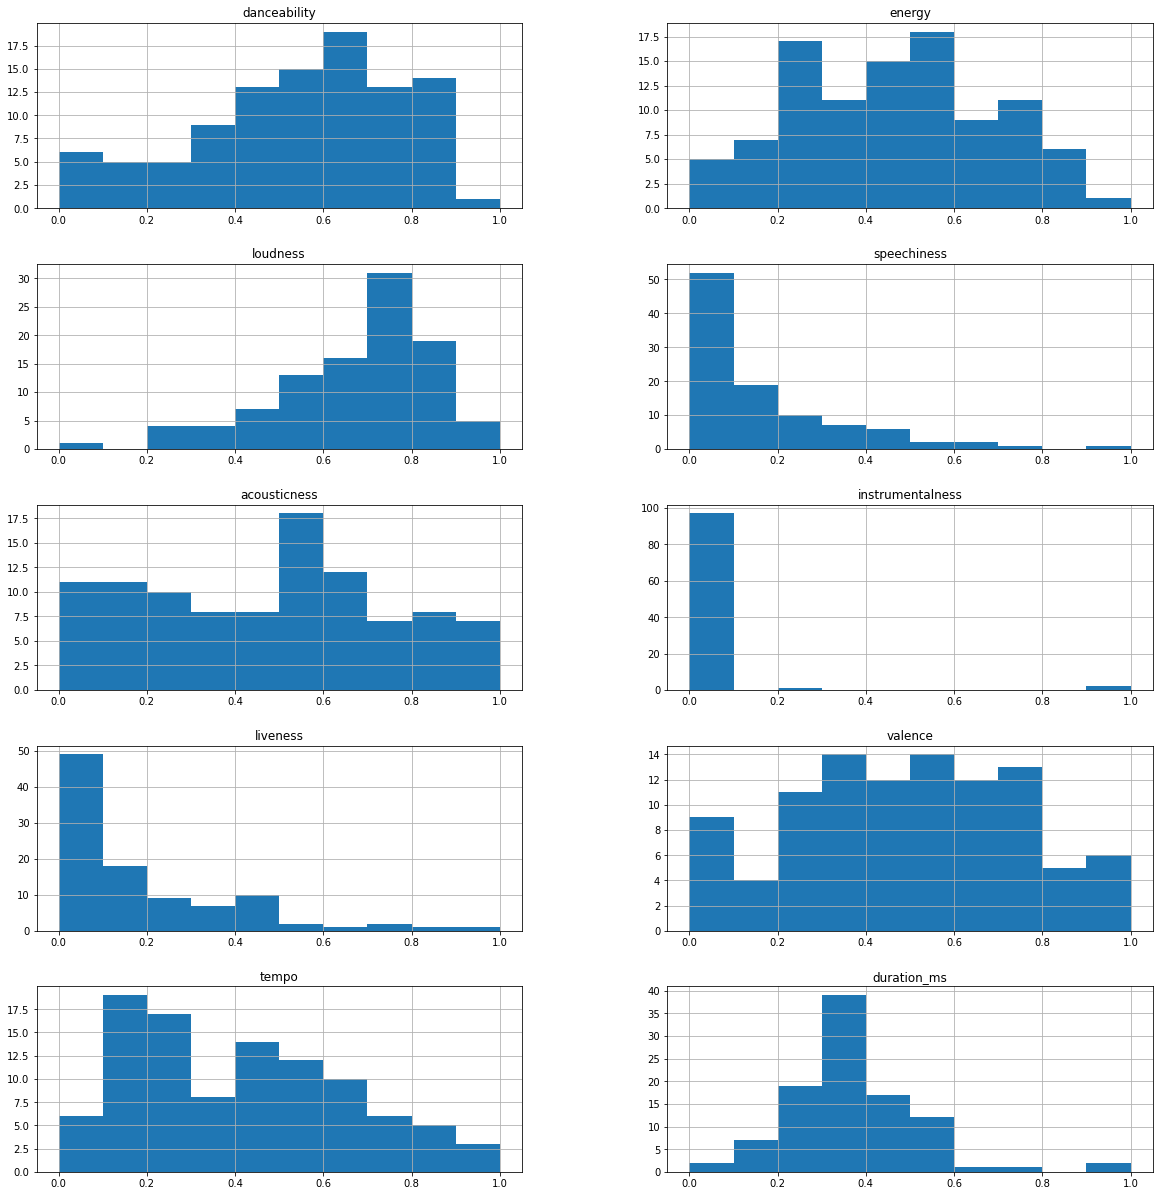

In [256]:
kindie_df.hist(layout=(7,2),figsize=(20, 30))

array([[<AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>],
       [<AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'valence'}>],
       [<AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

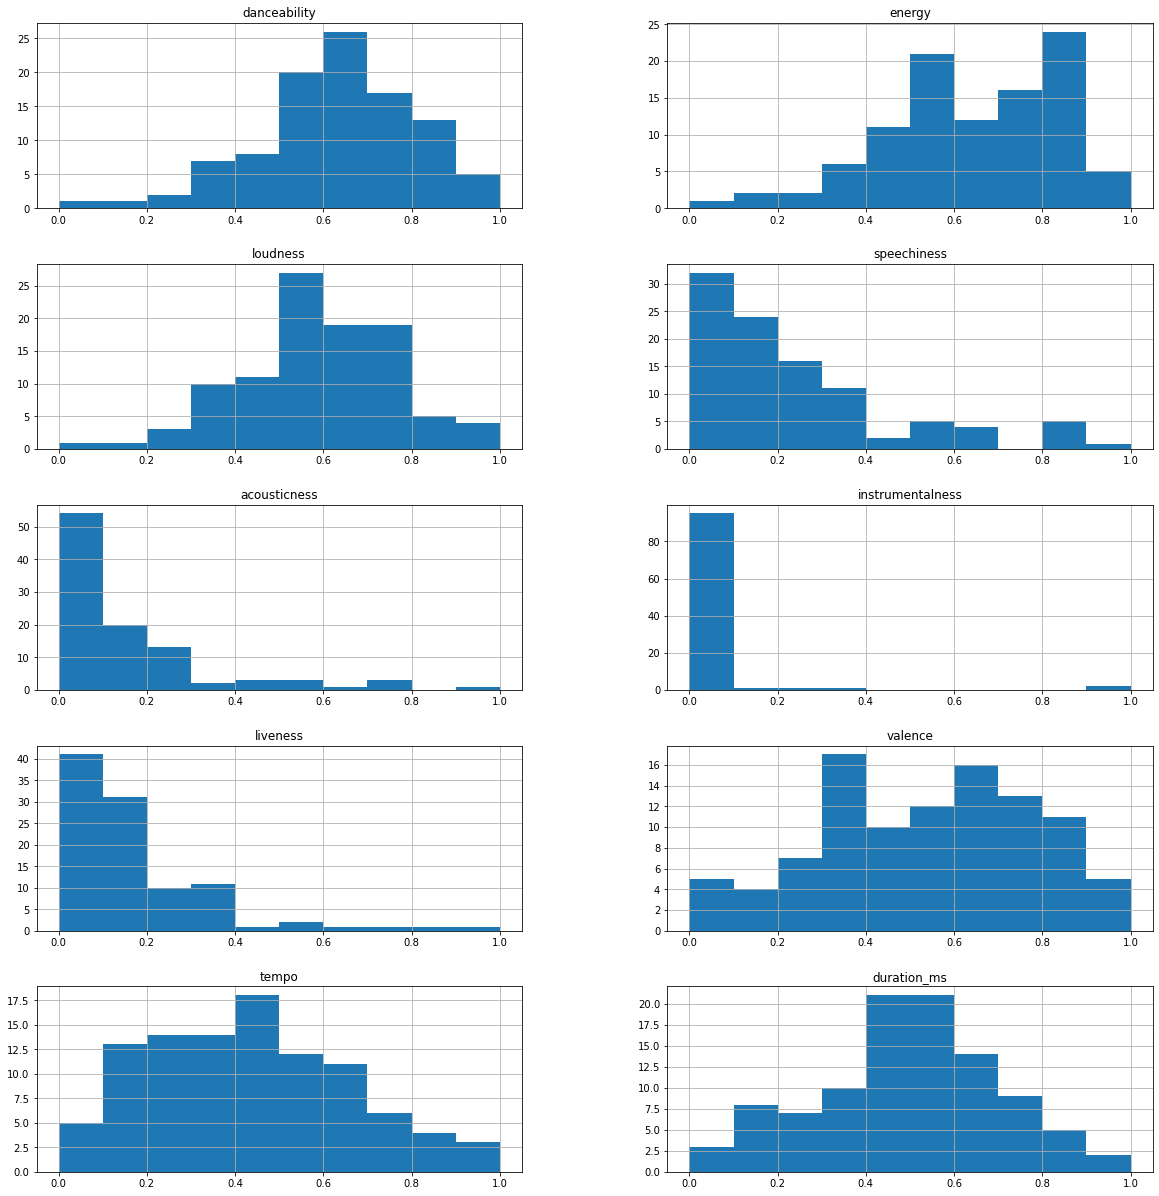

In [257]:
kpop_df.hist(layout=(7,2),figsize=(20, 30))

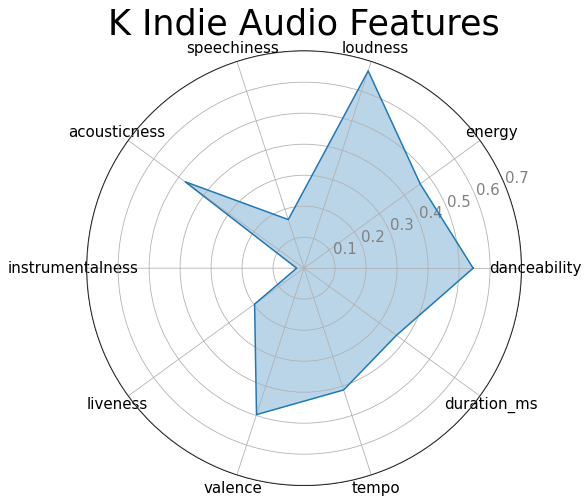

In [258]:
# plot size
fig = plt.figure(figsize=(12,8))

# convert column names into a list
categories = list(kindie_df.columns)

# number of categories
N = len(categories)

# create a list with the average of all features
value = list(kindie_df.mean())

# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.

value += value[:1]
# calculate angle for each category

angles = [n/float(N)*2*3.14159 for n in range(N)]
angles += angles[:1]

# plot
plt.polar(angles, value)
plt.fill(angles,value,alpha=0.3)

plt.title('K Indie Audio Features', size=35)

plt.xticks(angles[:-1],categories, size=15)
plt.yticks(color='grey',size=15)
plt.show()

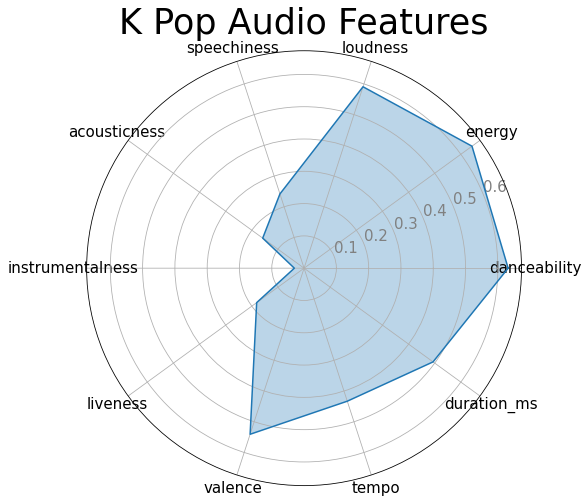

In [259]:
# plot size

import matplotlib.pyplot as plt2

fig_2 = plt2.figure(figsize=(12,8))

# convert column names into a list
categories_2 = list(kpop_df.columns)

# number of categories
N_2 = len(categories_2)

# create a list with the average of all features
value_2 = list(kpop_df.mean())

# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.

value_2 += value_2[:1]
# calculate angle for each category

angles_2 = [n/float(N_2)*2*3.14159 for n in range(N_2)]
angles_2 += angles_2[:1]

# plot
plt2.polar(angles_2, value_2)
plt2.fill(angles_2,value_2,alpha=0.3)

plt2.title('K Pop Audio Features', size=35)

plt2.xticks(angles_2[:-1],categories_2, size=15)
plt2.yticks(color='grey',size=15)
plt2.show()

# Takeaways from EDA

From the Radar Charts and Histograms, I see a notable difference in several audio features:

- Acousticness: Korean Indie/Rnb has higher acousticness than overall Kpop
- Danceability: Korean Indie/Rnb has lower danceability than overall Kpop
- Energy: Korean Indie/Rnb has lower energy than overall Kpop
- Duration_ms: Korean Indie/Rnb has a shorter duration of songs than overall Kpop

Given the stark differences in audio features, I'm confident I'll be able to distinguish between Korean Indie/Rnb and Kpop songs on a playlist. So let's build the model!


# Logistic Regression

In [260]:
x = testing_df[['danceability', 'energy', 'loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']]

y = testing_df[['playlist']]

In [261]:
model = sm.Logit(y, x)

result = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.262951
         Iterations 8


## Evaluating the model

In [262]:
#assigning binary values to prediction results
(result.predict(x) >= 0.5).astype(int)

0     0
1     1
2     1
3     1
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Length: 200, dtype: int64

In [263]:
#confusion matrix

result.pred_table()

array([[88., 12.],
       [12., 88.]])

In [264]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               playlist   No. Observations:                  200
Model:                          Logit   Df Residuals:                      190
Method:                           MLE   Df Model:                            9
Date:                Sat, 01 Jan 2022   Pseudo R-squ.:                  0.6206
Time:                        08:57:14   Log-Likelihood:                -52.590
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 2.276e-32
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
danceability        -5.4113      1.464     -3.696      0.000      -8.281      -2.542
energy              -9.7570      2.183     -4.470      0.000     -14.035      -5.479
loudness            15.1050      2.564      5.890      0.000      10.079      20.131
speechiness         -0.5288      1.274     -0.415      0.678      -3.026       1.969
acousticness         5.3174      1.198      4.440      0.000       2.970       7.665
instrumentalness     2.4752      1.916      1.292      0.196      -1.281       6.231
liveness             1.9421      1.192      1.630      0.103      -0.393       4.278
valence              1.2080      1.494      0.808      0.419      -1.721       4.137
tempo               -1.1270      0.972     -1.159      0.246      -3.032       0.778
duration_ms         -7.2358      1.777     -4.071      0.000     -10.720      -3.752
====================================================================================
"""

In [265]:
x = testing_df[['danceability', 'energy', 'loudness','acousticness', 'duration_ms']]

There are 5 variables with a p-value greater than 0.05, so I will remove those variables.

In [266]:
model = sm.Logit(y, x)

result = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.277701
         Iterations 8


In [267]:
#assigning binary value to each prediction to test results
y_score = (result.predict(x) >= 0.5).astype(int)

y_score

0     0
1     1
2     1
3     1
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Length: 200, dtype: int64

In [268]:
#confusion matrix
result.pred_table()

array([[88., 12.],
       [14., 86.]])

Removing the five variables ended up resulting in more False Positives. Given the small sample size (n = 200), and the accuracy of the model as is, I will leave those variables out.

In [269]:
#Accuracy percentage

total_observations = 200
correct = 88 + 86

accuracy = correct/total_observations
print(accuracy)

0.87


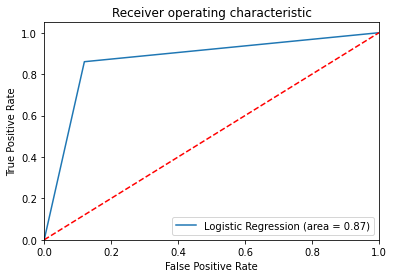

In [270]:
#ROC Curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y, y_score)
fpr, tpr, thresholds = roc_curve(y, y_score)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Testing my Discover Weekly Playlist Against Logistic Regression Model

Now that we have built a model with around 87% accuracy, I want to test it against my Discovery Weekly playlist to answer a couple of questions:

1. How many of my Discover Weekly songs belong in my Korean Indie RnB playlist?
2. How well does my model perform when I assess which songs actually would make it to my playlist (through physical observation)?

In [276]:
#pull Discovery Weekly Playlist from Spotify API

playlist_id_dw = '37i9dQZEVXcMk4j3xtrK2C'
results_dw = sp.playlist(playlist_id_dw)

In [279]:
#Pushing Discover Weekly tracks into a DataFrame

ids_dw = []

for item_dw in results_dw['tracks']['items']:
    track_dw = item_dw['track']['id']
    ids_dw.append(track_dw)

song_meta_dw = {'id':[], 'album':[], 'name':[], 'artist':[], 'explicit':[], 'popularity':[]}

for song_id_dw in ids_dw:
    #getting song's meta data
    meta_dw = sp.track(song_id_dw)
    
    #song id
    song_meta_dw['id'].append(song_id_dw)
    
    #album name
    album_dw = meta_dw['album']['name']
    song_meta_dw['album'] += [album_dw]
    
    #song name
    song_dw = meta_dw['name']
    song_meta_dw['name'] += [song_dw]
    
    #artists name
    s_dw = ', '
    artist_dw = s.join([singer_name_dw['name'] for singer_name_dw in meta_dw['artists']])
    song_meta_dw['artist'] += [artist_dw]
    
    #explicit
    explicit_dw = meta_dw['explicit']
    song_meta_dw['explicit'].append(explicit_dw)
    
    #song popularity
    popularity_dw = meta_dw['popularity']
    song_meta_dw['popularity'].append(popularity_dw)

song_meta_df_dw = pd.DataFrame.from_dict(song_meta_dw)

#check song features

features_dw = sp.audio_features(song_meta_dw['id'])

#change dictionary to dataframe

features_df_dw = pd.DataFrame.from_dict(features_dw)

#convert milliseconds to mins
#duration_ms: The duration of the track in milliseconds
#1 minute = 60 seconds = 60 * 1,000 milliseconds = 60,000 ms
features_df_dw['duration_ms'] = features_df_dw['duration_ms']/60000

#combine the two dataframes

final_df_dw = song_meta_df_dw.merge(features_df_dw)

In [280]:
#Collecting only music features from the DataFrame

music_feature_dw = final_df_dw[['danceability','energy','loudness','speechiness','acousticness',
                             'instrumentalness','liveness','valence','tempo','duration_ms']]

#Normalization scaling

music_feature_dw.loc[:] = min_max_scaler.fit_transform(music_feature_dw.loc[:])

music_feature_dw.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.621027,0.651409,0.679833,0.178671,0.411659,0.103446,0.204220,0.540834,0.401385,0.633756
std,0.282016,0.277633,0.234621,0.252007,0.298722,0.251041,0.215924,0.300901,0.244513,0.215081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.434072,0.449362,0.598604,0.037209,0.147541,0.000000,0.096572,0.302264,0.243774,0.505081
50%,0.684599,0.763158,0.726190,0.094889,0.400846,0.000022,0.121237,0.519308,0.381386,0.633621
75%,0.838608,0.828549,0.821039,0.178721,0.651772,0.005005,0.239967,0.791944,0.476938,0.771829
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [284]:
#Testing Discovery Weekly Data

x_dw = music_feature_dw[['danceability', 'energy', 'loudness','acousticness', 'duration_ms']]

result.predict(x_dw)
(result.predict(x_dw) >= 0.5).astype(int)

0     0
1     1
2     1
3     0
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    0
14    0
15    0
16    0
17    1
18    1
19    0
20    1
21    0
22    0
23    1
24    0
25    1
26    0
27    1
28    0
29    1
dtype: int64

Our model predicts that there are 11/30 songs that would belong on the Korean Indie RnB Playlist.

### Actual Results

Looking through my Discovery Weekly Playlist manually, there are actually only five songs I would add to my Korean Indie RnB playlist:

1. Darling by Young Jun
2. Walk in the Night by Moon Sujin
3. Chocolate by DAY6
4. This Night by GroovyRoom
5. Come Back to My City by Iri

Out of these five songs, the model correctly predicted three songs to belong on the Korean Indie RnB playlist. While this performance is low, I'm actually pleased with the results given the small sample size I built the model off of.

# How to Improve the Model

I initially wanted to build the model off of my "Liked Songs" playlist on Spotify, but unfortunately there isn't a way to access the Spotify URI for your Liked Songs which limited my analysis to pullable playlists on Spotify. Due to this constraint, my sample size to build the model was limited. To better train the model, I would like to either build larger playlists or if Spotify offered, build it off of my Liked Songs.

Another consideration was that I didn't take into account a categorical variable for song or artist genre. This makes it difficult to compare the Discovery Weekly songs against my model given that not all of the Discovery Weekly songs are in the Korean music genre which makes the comparison more challenging given our model didn't take genre as an input.

There were multiple songs on my Discovery Weekly that had the same audio features as Korean Indie RnB songs, but were not made by Korean artists which is why I personally wouldn't add them to the Korean Indie Rnb Playlist.

In sum, I would like to add more features and tracks to improve the performance of my model for next time!

# Conclusion

This project helped me better understand how Data Scientists at Spotify utilize machine learning to build some of the best personalized playlists in the world. I used a fairly simple regression model with a small set of training data and was able to build a model I was satisfied with for my personal use.

Imagining working at Spotify with an even more robust access to millions of songs and more features to add to my model is an incredibly exciting thought. While there are limitations in the data I can access, I am very grateful for Spotify for providing access to the audio features that are available so people like me can build models for fun or use.

Going forward, I'll probably view my Discovery Weekly playlist a bit differently and will keep using this model to weed out which songs I should check out for the thirty songs I receive each week!

Spotify team, if you ever see this - I would love to have the option to personally filter/request categorical variables for my Discover Weekly to curate a playlist of songs I want to discover for a specific genre. Or have a Discovery Weekly for each genre!